In [22]:
import numpy as np

# Question 1

In [23]:
def Stanford_Inverse_Pos_Kine(px,py,zc,d1,a1,a2):
    theta1 = np.arctan2(px,py)
    r = np.sqrt(px**2 + py**2)
    s = zc - d1
    theta2 = np.arctan2(r,s) + np.pi/2
    
    d3 = np.sqrt(r**2 +s**2) - a2
    return theta1, theta2, d3


# Question 2

In [24]:
def Scara_inverse_Pos_Kine(px,py,a1,a2):
    c2 = (px**2 + py**2 - a1**2 - a2**2)/(2*a1*a2)
    theta2 = np.arctan2(np.sqrt(1-c2**2),c2)

    theta1 = np.arctan2(px,py) - np.arctan2(a1 + a2*np.cos(theta2),a2*np.sin(theta2))

    return theta1,theta2


# Question 3
Code taken directly from Assignment 3

In [25]:
class manipulator():
    def __init__(self,dh_params, config=['R','R']):
        # configuration of the manipulator. User has 2 choices "R"->revolute. "P"->prismatic.
        # Default configuration is a 2R manipulator with all the angles at 0 degrees and lengths being 1 unit.
        self.config = config 
        # User must input the dh parameters in matrix form i.e. "R"->revolute
        # [[a1 , alpha1 , d1, theta1]
        #  [a2 , alpha2 , d2, theta2]
        #  .
        #  .
        #  .
        #  [an , alphan , dn, thetan]]
        # n being the nth link of the manipulator.
        self.dh=dh_params
    
    def calc_tranfMatrix(self, dh_params,i):
        # Calculating Trnasformation matrix
        a, alpha,d,theta = dh_params
        A = np.array([[np.cos(theta), -np.sin(theta)*np.cos(alpha),  np.sin(theta)*np.sin(alpha), a*np.cos(theta)],
                      [np.sin(theta),  np.cos(theta)*np.cos(alpha), -np.cos(theta)*np.sin(alpha), a*np.sin(theta)],
                      [            0,                np.sin(alpha),                np.cos(alpha),               d],
                      [            0,                            0,                            0,               1]])
        return A 

    def forward_kinematics(self,):
        tr=self.calc_tranfMatrix(self.dh[0],0)
        Trs = [tr]
        # Calculating the individual transformation matrices. And appending to the T matrix in the following form.
        # A1
        # A1A2
        # A1A2A3 ... 
        for i in range(len(self.dh)-1):
            tr = np.matmul(tr,self.calc_tranfMatrix(self.dh[i+1],i+1))
            Trs.append(tr)

        # Calculating the jacobian matrix
        h = []
        for i in range(len(self.config)):
            temp2 = np.array([0,0,0])
            if self.config[i]=='R':
                temp2 = np.array([0,0,1])
            if  i ==0:
                temp = np.array(Trs[-1])

            else:
                temp = np.array(Trs[-1]) - np.array(Trs[i-1])
            
            h.append(np.cross(temp2,temp[:3,3:].transpose()).transpose())
        
        # Velocity jacobian
        J_v = h[0]
        for i in range(len(self.config)-1):
            J_v = np.hstack((J_v,h[i+1]))
        
        
        # Angular velocity jacobian
        J_omega = np.array([[0],[0],[1]])
        if self.config[0]=='P':
            J_omega = np.array([[0],[0],[0]])

        for i in range(len(self.config)-1):
            temp = np.array([[0],[0],[1]])

            if self.config[i+1]=='P':
                temp = np.array([[0],[0],[0]])
            J_omega = np.hstack((J_omega,temp))
        
        # Overall Transformation matrix T06.
        transformation_matrix = np.array(Trs[-1])
        # Manipulator jacobian
        J = np.vstack((J_v,J_omega))

        return {'transformation_matrix':transformation_matrix,'jacobian':J}

In [26]:
'''
Example of 3R revolute manipulator
'''
manipulator_config = ['R','R','R']
dh_params = [[1,0,0,np.pi/3],
             [1,0,0,0],
             [1,0,0,0]]

mani = manipulator(dh_params,manipulator_config)
a = mani.forward_kinematics()
print('transformation matrix')
print(np.round(a['transformation_matrix'].astype('float'),3))
print('jacobian')
print(np.round(a['jacobian'].astype('float'),3))

# Velocity of joint angles given end effector velocities
#  Use the following code by giving an input qdots.

# Ensuring the ranks of jacbian and the qdot are equal i.e. 
# removing all zero rows from the jacobian
new_jacob = []
for i in range(len(a['jacobian'])):
    if all(v==0 for v in a['jacobian'][i]):
        pass
    else:
        new_jacob.append(a['jacobian'][i])

# Given End Effector velocities
print('End Effector to joint Velocity')
xdot = [1,1,1]
qdot = np.matmul(np.linalg.pinv(new_jacob),np.array(xdot))
print(qdot)


transformation matrix
[[ 0.5   -0.866  0.     1.5  ]
 [ 0.866  0.5    0.     2.598]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     0.     1.   ]]
jacobian
[[-2.598 -1.732 -0.866]
 [ 1.5    1.     0.5  ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 1.     1.     1.   ]]
End Effector to joint Velocity
[-0.84967937  0.33333333  1.51634604]


# Question 6

In [27]:
def Spherical_Wrist(Rotation_matrix):
    rot = Rotation_matrix.copy()

    theta = np.arctan2(rot[3][3],np.sqrt(rot[3][3]))
    phi = np.arctan2(rot[1][3],rot[2][3])
    si = np.arctan2(-rot[3][1],rot[3][2])


    return theta,phi,si

# Question 7
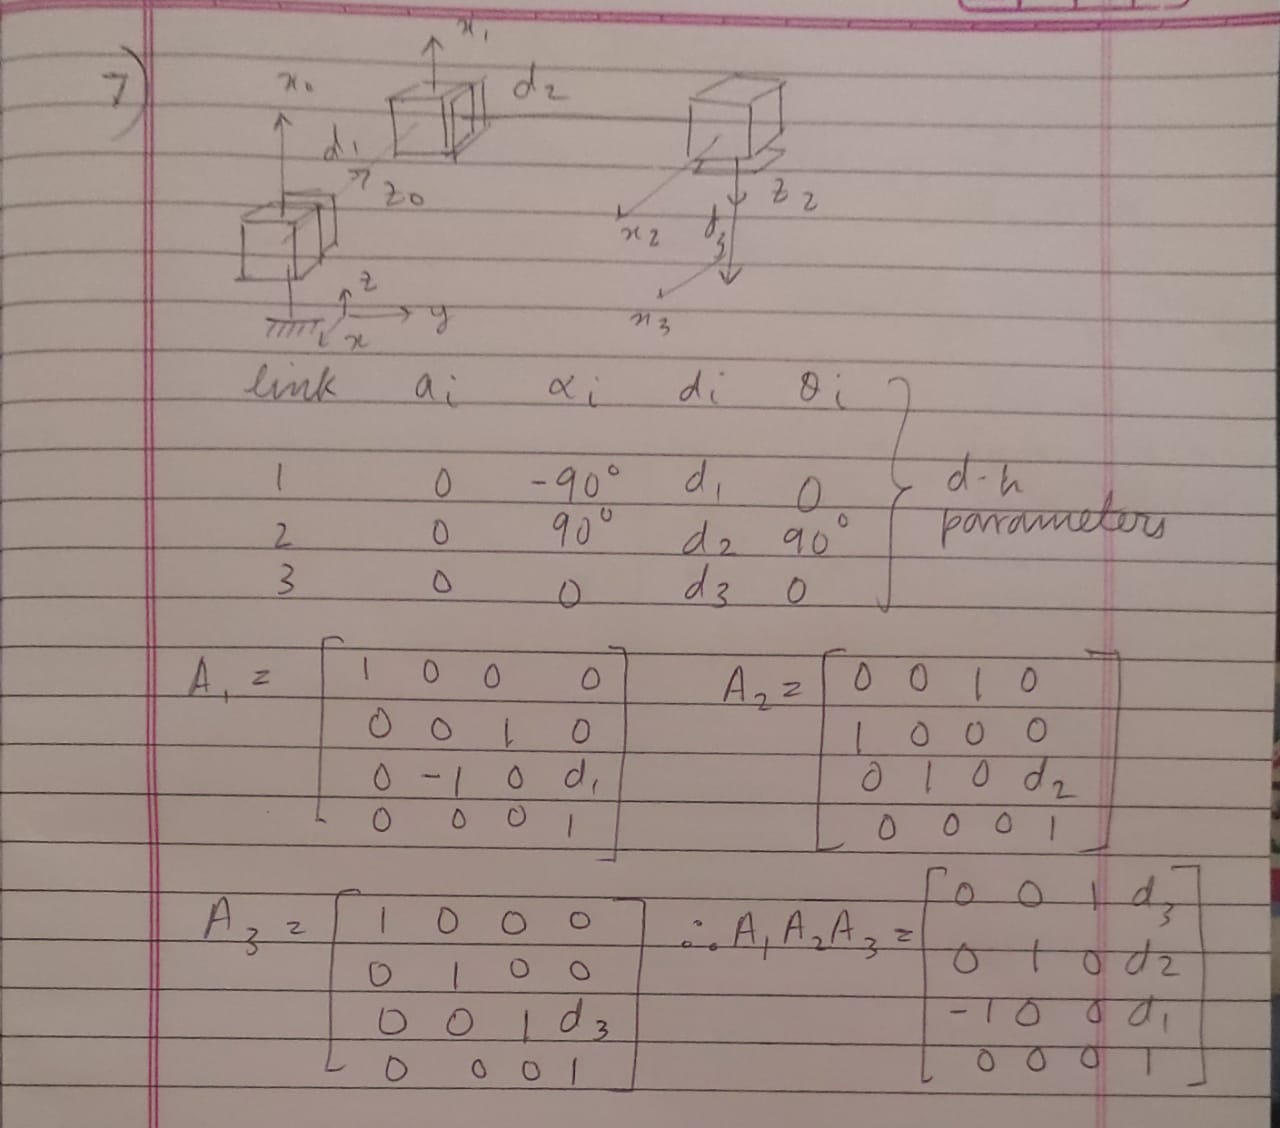


In [29]:
'''
3d Printer ppp joints
'''
manipulator_config = ['P','P','P']
d1,d2,d3 = 1,1,1
dh_params = [[0,-np.pi/2,d1,0],
             [0,np.pi/2, d2,np.pi/2],
             [0,0,       d3,0]]

mani = manipulator(dh_params,manipulator_config)
a = mani.forward_kinematics()
print('transformation matrix')
print(np.round(a['transformation_matrix'].astype('float'),3))
print('jacobian')
print(np.round(a['jacobian'].astype('float'),3))



transformation matrix
[[ 0. -0.  1.  1.]
 [ 0.  1.  0.  1.]
 [-1.  0.  0.  1.]
 [ 0.  0.  0.  1.]]
jacobian
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


Jacobian can not be used to calculate the end effector velocities. This is because the the angles are fixed and do not change unlike the manipulators with revolute joints. Thus, we can directly find the end effector velocities given the velocities of all the prismatic joints.

$ \dot{d_1} = \dot{x_p} $ <br>
$ -\dot{d_2} = \dot{y_p} $  
$ -\dot{d_3} = \dot{z_p} $


# Question 8
Keeping the figure in Question 7 as the refernece, we infer that the inverse kinematics can be stated as:

$d_1 = x_p $ <br>
$ -d_2 = y_p $  
$ -d_3 = z_p $